# The Roads of California - A Network Analysis Project
### by Jimi Hytönen, Hanna Holtdirk and Basil Mashal

## Outline
1. Analyzing the Structure of the Network
    - Building and Visualizing the Network
    - Exploring the Points of Interest
    - Connectivity, Degree Distribution, Clustering Coefficient
    - Centrality Measures
2. Community Detection
3. Predictions through Machine Learning
    - Link Predicition
    - Classification of Points of Interest

# 1. Analyzing the Structure of the Network

In this section, we analyze the general structure of the road network by first visualizing the network to get a better idea of the data and then using some basic analysis tasks like centrality measures.


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Building and Visualizing Network

In [2]:
df_nodes = pd.read_csv("data/nodes.dat", delimiter = " ", header = None)
df_nodes.columns = ['nodeID', 'longitude', 'latitude']
df_nodes.head()

,nodeID,longitude,latitude
0,0,-121.904167,41.974556
1,1,-121.902153,41.974766
2,2,-121.896790,41.988075
3,3,-121.889603,41.998032
4,4,-121.886681,42.008739


In [3]:
df_edges = pd.read_csv("data/edges.dat", delimiter = " ", header = None)
df_edges.columns = ['edgeID', 'start node ID', 'end node ID', 'distance']
df_edges.head()

,edgeID,start node ID,end node ID,distance
0,0,0,1,0.002025
1,1,0,6,0.005952
2,2,1,2,0.014350
3,3,2,3,0.012279
4,4,3,4,0.011099


In [4]:
# build graph for road network
G = nx.Graph()

for i ,row in df_nodes.iterrows():
    G.add_node(int(row["nodeID"]), pos = (row["longitude"], row["latitude"]))
    
for i, row in df_edges.iterrows():
    G.add_edge(int(row["start node ID"]), int(row["end node ID"]))

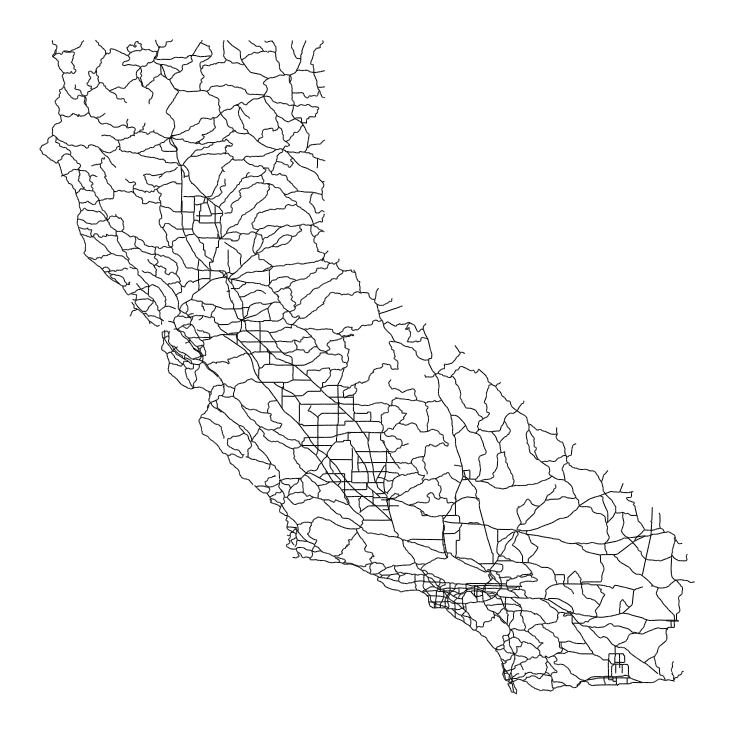

In [5]:
# plot road network 
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)

## Exploring the Points of Interest

In [6]:
df_places = pd.read_csv("data/places.dat", delimiter = " ", header = None)
df_places.columns = ['name', 'longitude', 'latitude']

df_places.head()

,name,longitude,latitude
0,airport,-114.18639,34.30806
1,airport,-114.43083,34.52750
2,airport,-114.52667,33.86944
3,airport,-114.57528,34.18389
4,airport,-114.60194,34.81944


In [7]:
# number of points of interest for each category
df_test = df_places.groupby(['name'])
df_test.size()

name
airport     995
arch         20
area        287
arroyo        2
bar         278
           ... 
trail      1187
tunnel      128
valley     7596
well        237
woods       197
Length: 63, dtype: int64

In [8]:
# build graph with points of interest (poi) as nodes
G_places = nx.Graph()

for i ,row in df_places.iterrows():
    G_places.add_node(i, pos = (row["longitude"], row["latitude"]), name = row["name"])

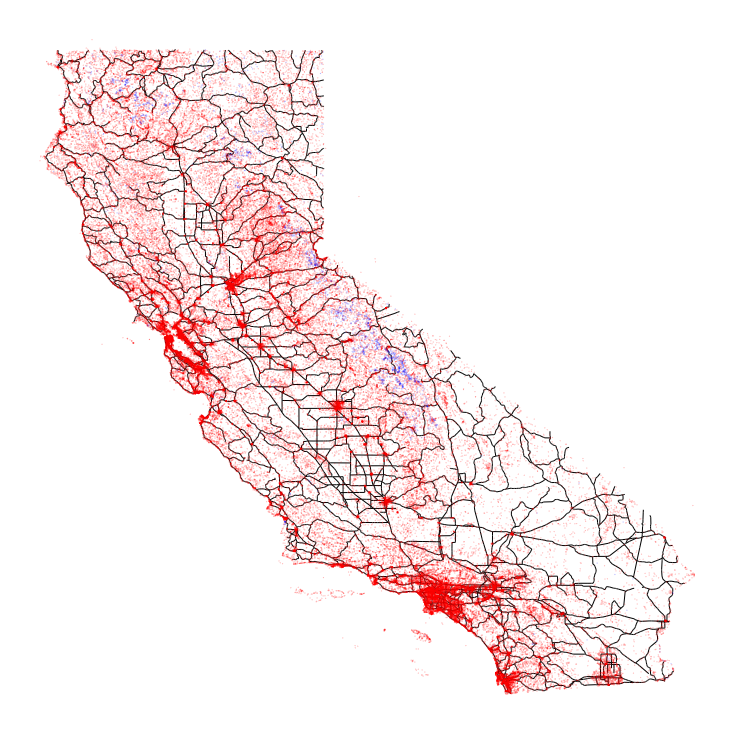

In [9]:
# every poi red except lake blue
color_map = []
nodes = nx.get_node_attributes(G_places, 'name')
for node in nodes.values():
    if node=='lake':
        color_map.append('blue')
    else: 
        color_map.append('red')

# plot graph with points of interest on top
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)
pos = nx.get_node_attributes(G_places, 'pos')
nx.draw(G_places, pos, node_size = 0.01, node_color=color_map)

### Merge Points of Interest with Road Network

In [10]:
"""
For each edge:
Start Node ID, End Node ID, Number of Points on this Edge, Edge Length
    For each point on this edge:
    Category ID, Distance of This Point to the Start Node of This Edge 
"""

map_file = open("data/mapformat.dat", "r")  
G_merged = nx.Graph()
for line in map_file:
    einfo = line.split()
    num_poi = int(einfo[3])
    pois = []
    if num_poi > 0:
        pois_info = next(map_file).split()
        for i in range(num_poi):
            pois.append({'categoryID': pois_info[i*2], 'distance': float(pois_info[i*2+1])})
    G_merged.add_edge(int(einfo[0]), int(einfo[1]), length=float(einfo[2]), pois=pois)
    
# add node information
for v in G_merged:
    G_merged.nodes[v]['pos'] =  G.nodes[v]['pos']

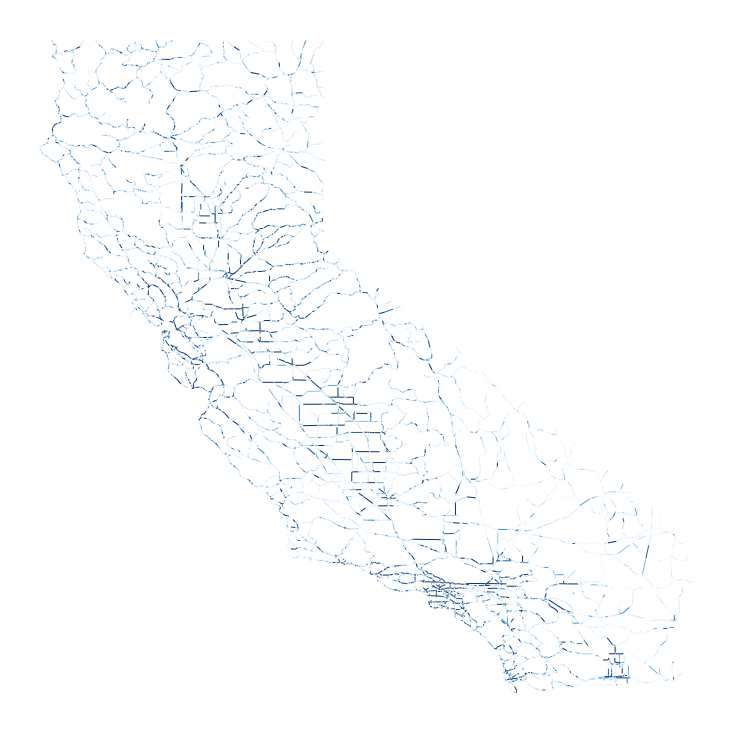

In [11]:
def edges_num_pois(g):
    """ Calculate the number of points of interest on all edges
    
    Arguments:
    g -- graph containing the edges
    
    Returns:
    dict with the edges as key and the number of points of interest as values
    """
    return {e: len(g[e[0]][e[1]]['pois']) for e in g.edges}

# plot merged graph with intensity of edge based on number of points of interest 
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G_merged, 'pos')
nx.draw(G_merged, pos, node_size=0.0, edge_color=edges_num_pois(G_merged).values(), edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=15)

## Connectivity

In [12]:
# check if all nodes are connected
nx.is_connected(G)

True

## Degree Distribution

In [13]:
# get distribution from list l
def get_distribution(l):
    """ Calculate the distribution for a given list of values
    
    Arguments:
    l -- list of values for which the distribution is calculated
    
    Returns:
    x -- list with the different values that appear in l in ascending order
    y -- amount of the values in x in l
    """
    l.sort()
    x = []
    y = []
    curr_d = -1
    index = -1
    for d in l:
        if curr_d != d:
            curr_d = d
            index = index + 1
            x.append(d)
            y.append(0)
        y[index] = y[index] + 1
    return x, y

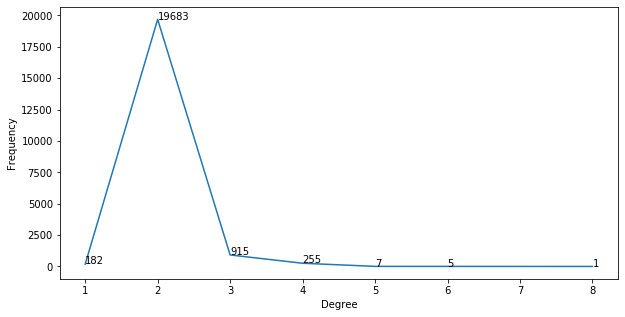

In [14]:
# plot degree distribution
degrees = [G.degree(v) for v in G.nodes]
x, y = get_distribution(degrees)
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
for i,j in zip(x,y):
    plt.annotate(str(j),xy=(i,j))

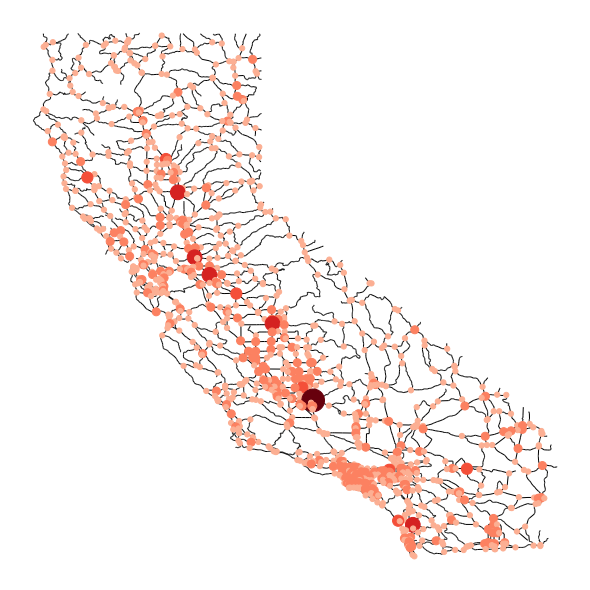

In [15]:
# visualize node degrees (only nodes with deg > 2)
plt.figure(figsize=(8,8))
pos = nx.get_node_attributes(G, 'pos')
degrees = [G.degree(v) for v in G.nodes]
sizes = [d**3 if d > 2 else 0.0 for d in degrees]
nx.draw(G, pos, node_size=sizes, node_color=degrees, cmap=plt.cm.Reds)

## Clustering Coefficient

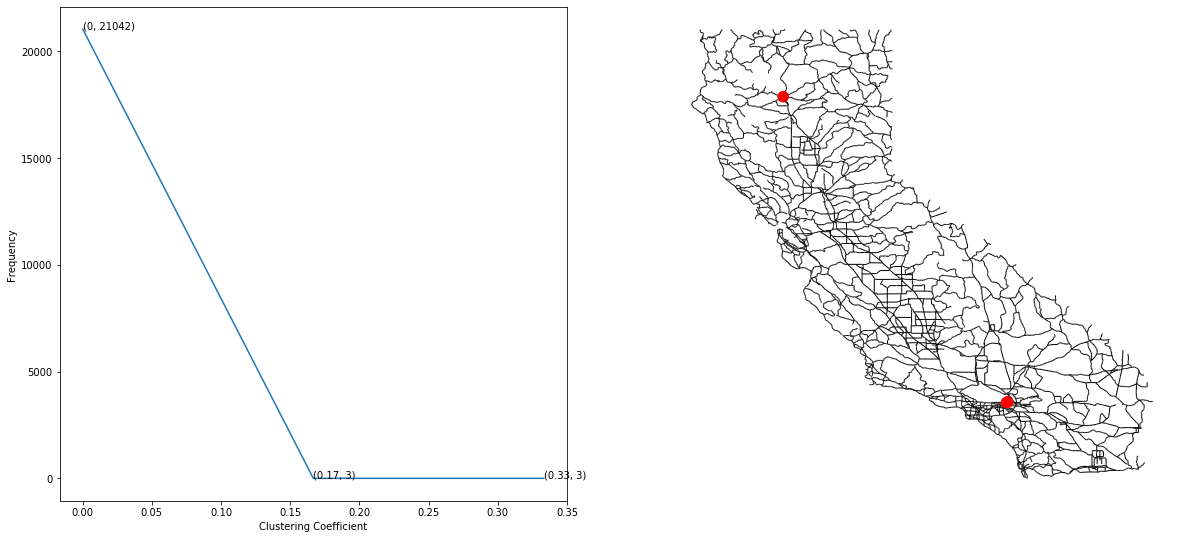

In [16]:
# local clustering coefficients -> distribution
clustering = nx.clustering(G)
x, y = get_distribution(list(clustering.values()))

plt.figure(figsize=(20, 20))
plt.subplot(223)
plt.plot(x, y)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
for i,j in zip(x,y):
    plt.annotate(str((round(i, 2), j)),xy=(i,j))
    
plt.subplot(224)
nx.draw(G, pos, node_size=[100 if c > 0 else 0.0 for c in clustering.values()], node_color='r')

In [17]:
# average global clustering coefficient
avg_clustering = nx.average_clustering(G)
print("The average global clustering coefficient is ca. %.6f." % avg_clustering)

The average global clustering coefficient is ca. 0.000071.


## Centrality Measures

In [18]:
# degree centrality: already did this one above
deg_centr = nx.degree_centrality(G_merged) 
deg_list = list(deg_centr.values())

# betweenness centrality: (relative) number of shortest paths that pass through it
betw_centr = nx.betweenness_centrality(G_merged, weight='length', k=20) # approximate from 20 nodes each
betw_list = list(betw_centr.values())

# eigenvector centrality == pagerank
eig_centrality = nx.eigenvector_centrality(G_merged, weight='length')
eig_list = list(eig_centrality.values())

# katz centrality
katz_centrality = nx.katz_centrality(G_merged, weight='length')
katz_list = list(katz_centrality.values())

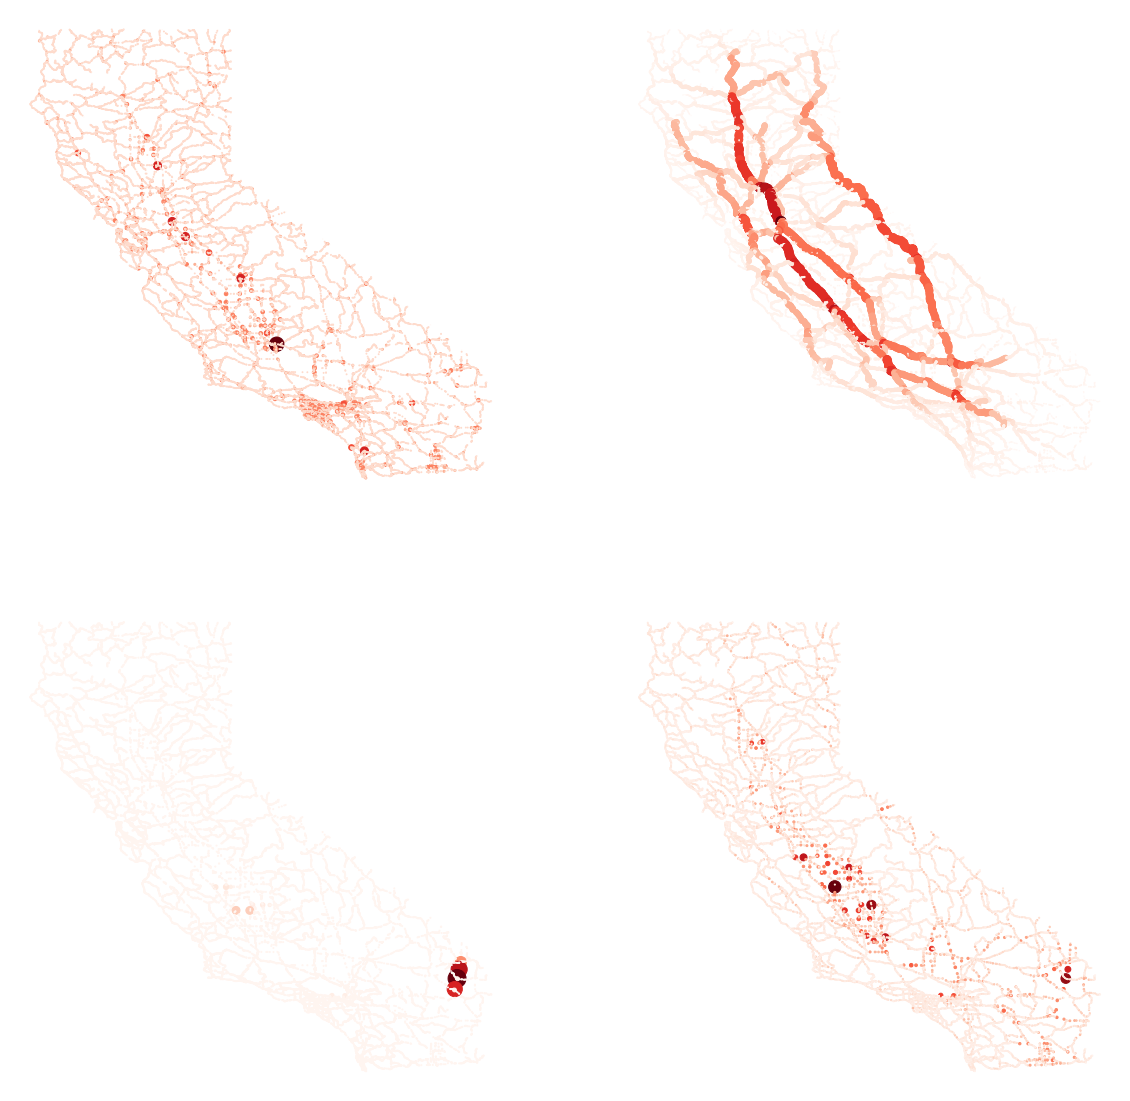

In [19]:
# plot the different centrality measures; for a higher centrality the size and color intensity gets bigger

pos = nx.get_node_attributes(G_merged, 'pos')

plt.figure(figsize=(20,20))

plt.subplot(221)
nx.draw(G_merged, pos, edgelist=[], node_size=[(v*10000)**4 for v in deg_list], node_color=deg_list, cmap=plt.cm.Reds)

plt.subplot(222)
nx.draw(G_merged, pos, edgelist=[], node_size=[(v*500) for v in betw_list], node_color=betw_list, cmap=plt.cm.Reds)

plt.subplot(223)
nx.draw(G_merged, pos, edgelist=[], node_size=[1+(v*500) for v in eig_list], node_color=eig_list, cmap=plt.cm.Reds)

plt.subplot(224)
nx.draw(G_merged, pos, edgelist=[], node_size=[(v*145)**110 for v in katz_list], node_color=katz_list, cmap=plt.cm.Reds)

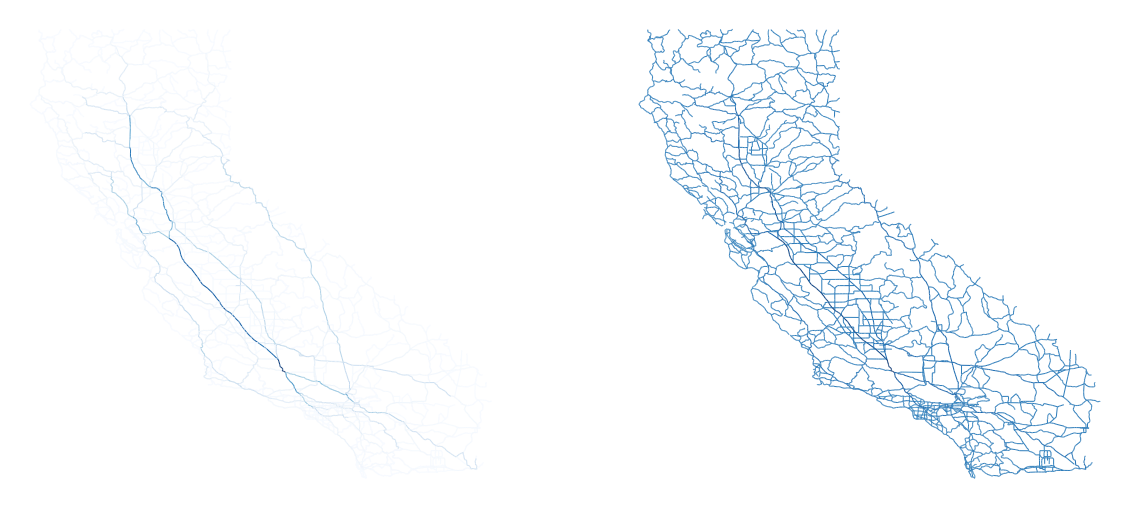

In [20]:
# edge betweenness centrality
edge_betw_centr = nx.edge_betweenness_centrality(G_merged, weight='length', k=20) 
test_measure = edge_betw_centr.copy()
num_pois = edges_num_pois(G_merged)

for k in edge_betw_centr.keys():
    test_measure[k] = edge_betw_centr[k] - num_pois[k]*1e-06

plt.figure(figsize=(20,20))
plt.subplot(221)
nx.draw(G_merged, pos, node_size=0.0, edge_color=list(edge_betw_centr.values()), edge_cmap=plt.cm.Blues)

plt.subplot(222)
nx.draw(G_merged, pos, node_size=0.0, edge_color=list(test_measure.values()), edge_cmap=plt.cm.Blues)

# 2. Community Detection

In this section, we try to detect communities of the network that correspond to the counties of California. We use a the Girvan-Newman method with our own definition of the edge to remove in each iteration. Because there are 58 counties in California, we stop the algorithm after having discovered 58 communities. 

In [21]:
# execution may take some time! (ca. 5 min)

from networkx.algorithms import community
import itertools
import operator

def mvl(g):
    """ Find the most valuable edge by a self-defined measure
    
    Arguments:
    g -- graph containing the edges to be measured
    
    Returns:
    most valuable edge
    """
    centr = nx.edge_betweenness_centrality(g, weight='length', k=20) # approximate betweeness with 20 nodes
    num_pois = edges_num_pois(g) 
    for k in centr.keys():
        centr[k] = centr[k] - num_pois[k]*1e-06 # consider betweeness centrality and number of pois on the edge
    return max(centr.items(), key=operator.itemgetter(1))[0]
    
com_gen = community.girvan_newman(G_merged, most_valuable_edge=mvl)

# generate 58 communities (corresponding to 58 counties)
k = 0
while k < 58:
    communities = next(com_gen)
    k = len(communities)

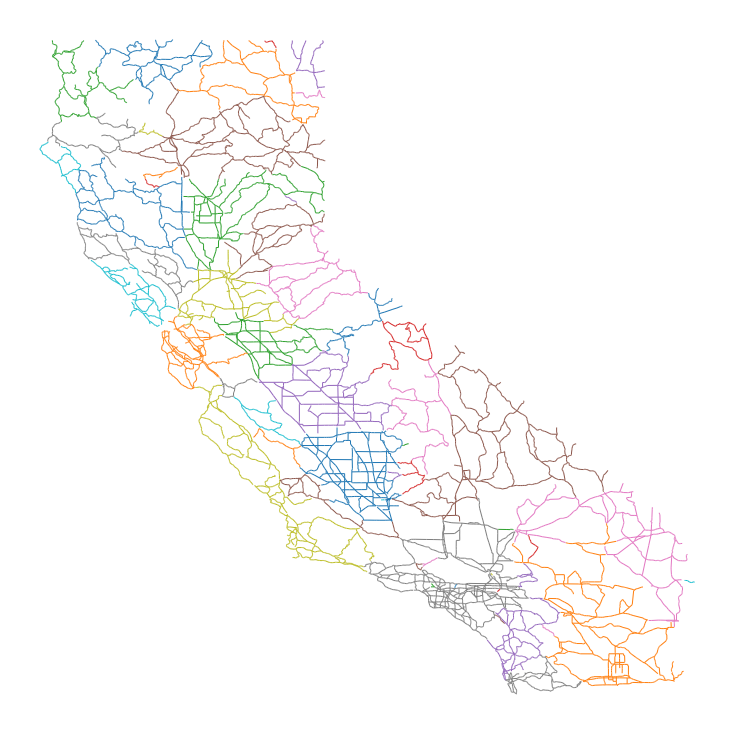

In [22]:
colors = []
for u,v in G_merged.edges:
    found = False
    for i in range(58):
        if not found and u in communities[i] and v in communities[i]:
            colors.append(plt.cm.tab10(i%10))
            found = True
    if not found:
        colors.append('white')

plt.figure(figsize=(10,10))
nx.draw(G_merged, nx.get_node_attributes(G_merged, 'pos'), edge_color=colors, node_size = 0.0)

(-0.5, 696.5, 769.5, -0.5)

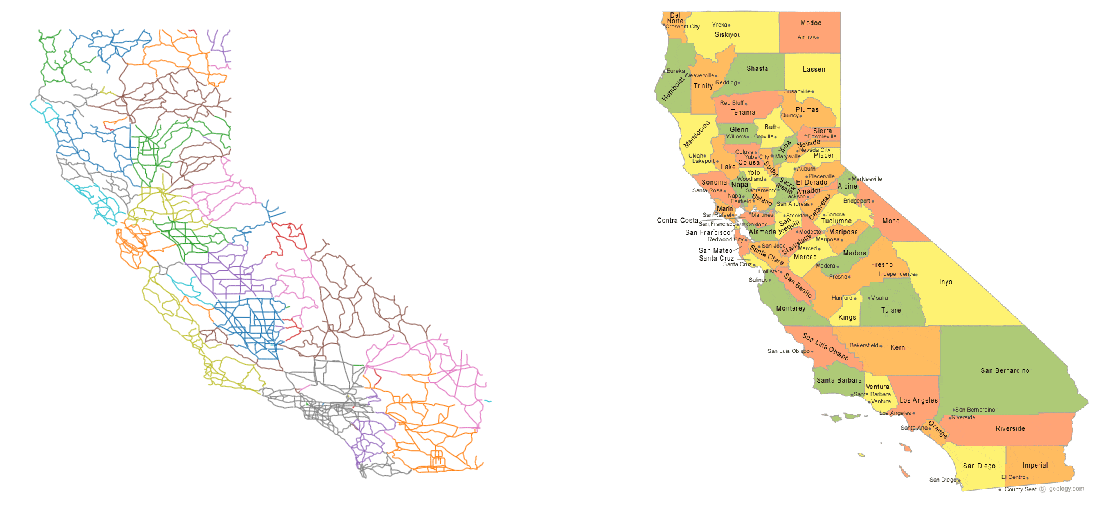

In [23]:
import matplotlib.image as mpimg

# compare communities to real counties
plt.figure(figsize=(20,20))
plt.subplot(221)
nx.draw(G_merged, nx.get_node_attributes(G_merged, 'pos'), edge_color=colors, node_size = 0.0)
plt.subplot(222)
plt.imshow(mpimg.imread('data/counties.png'))
plt.axis('off')

# 3. Predictions through Machine Learning

In this section, we make some predictions about the network through machine learning. 
First, we make a link prediction to predict where there should be roads in the network. 
Then we classify the points of interest by category, using a subset of all available categories. 
For both prediction we do classification with the quadratic discriminant analysis. 

## Link Prediciton

In [24]:
import random
import math

def filter_nodes_by_pos(g, pos_list, delta=0.0):
    """ Filters the nodes of a graph by removing the nodes that are outside the boundary (- delta).
    
    Arguments:
    g -- graph to be filterd
    pos_list -- positions that infer the boundries
    delta -- if positive, the boundary gets smaller by this value in each direchtion
    
    Returns:
    new graph without the nodes outside the boundary
    """
    x_max = -math.inf
    y_max = -math.inf
    x_min = math.inf
    y_min = math.inf
    for x,y in pos_list:
        if x > x_max:
            x_max = x
        if x < x_min:
            x_min = x
        if y > y_max:
            y_max = y
        if y < y_min:
            y_min = y          
    graph = g.copy()
    for n in g.nodes:
        x,y = graph.nodes[n]['pos']
        if x > x_max-delta or x < x_min+delta or y > y_max-delta or y < y_min+delta:
            graph.remove_node(n)
    return graph
    
# choose one community to analyze 
def choose_community(min_size, max_size, delta=0.0, i=0):
    """ Choose one community with certain size limitations and filter the points of interests.
    
    Arguments:
    min_size -- minimal amount of nodes in the community
    max_size -- maximal amount of nodes in the community
    delta -- if positive, the boundary for the points of interests gets smaller by this value in each direchtion
            (primarily used for testing)
    i -- index of community where to start the search
    
    Returns:
    graph -- graph of the chosen community
    places -- points of interest relevent to this community
    i -- the index of the chosen community
    """  
    community = communities[i]
    while len(community) < min_size or len(community) > max_size:
        i = (i+1) % 58
        community = communities[i]
    graph = G.subgraph(community)
    pos = nx.get_node_attributes(graph, 'pos')
    pos_list = list(pos.values())
    # make graph with POIs in the community
    places = filter_nodes_by_pos(G_places, pos_list, delta)
    return graph, places, i

In [25]:
def filter_nodes_by_attribute(g, attribute, values):
    """ Filter nodes of a graph that have one of the given values for the given attribute.
    
    Arguments:
    g -- graph to be filtered (stays unmodified)
    attribute -- node attribute to filter by
    values -- values that the attribute can have by which to filter the nodes
    
    Returns:
    new graph containing only the nodes that have one of the values for the attribute
    """
    new_g = g.copy()
    for n in g.nodes:
        x,y = g.nodes[n]['pos']
        if (not g.nodes[n][attribute] in values) or math.isnan(x) or math.isnan(y):
            new_g.remove_node(n)
    return new_g

In [26]:
def distance(x1, y1, x2, y2):
    """ Calculate distance between two points"""
    return np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

def edge_features(g, edge, filtered_pois):
    """ Build the feature vector of an edge for link prediciton
    
    Arguments:
    g -- graph containing the edge 
    edge -- edge for which the feature vector should be computed
    
    Returns:
    vector, i.e., list, of size 2 with the features
    """
    u, v = edge
    features = []
    
    # distance 
    x1, y1 = g.nodes[u]['pos']
    x2, y2 = g.nodes[v]['pos']
    dist = distance(x1, y1, x2, y2)
    features.append(dist)
    
    # num points of interest of (a) certain type(s), e.g. airport, between nodes
    num = 0
    for n in filtered_pois.nodes:
        x, y = filtered_pois.nodes[n]['pos']
        if abs(distance(x1, y1, x, y) + distance(x2, y2, x, y) - dist) < 0.005:
            num = num + 1
    features.append(num)
    
    return features

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def qda_predict(X, y, test):
    """ Performs quadratic discriminant analysis
    
    Arguments:
    X -- feature vectors for the training set
    y -- labels for the training set
    test -- feature vectors for the test set
    
    Returns:
    label predictions for the test set
    """ 
    qda = QuadraticDiscriminantAnalysis()
    return qda.fit(X, y).predict(test)

def num_misclass(predicted, expected):
    """ Evaluates the prediction based on number of misclassifications
    
    Arguments:
    predicted -- list with predicted labels
    expected -- list with expected labels
    
    Returns:
    missclass -- number of misclassifications
    false_pos -- number of false positives (only makes sense if only 2 classes)
    false_neg -- number of false negatives (only makes sense if only 2 classes)
    """ 
    misclass = 0
    false_pos = 0
    for i in range(len(predicted)):
        if predicted[i] != expected[i]:
            misclass = misclass + 1
            if predicted[i]  == 1:
                false_pos = false_pos + 1
    false_neg = misclass - false_pos
    return misclass, false_pos, false_neg

In [28]:
def road_prediction(min_size, max_size, com_index=0):
    """ Makes a link (/road) prediction for one community through machine learning classification 
    with two classes (0: no edge, 1: edge).
    
    Arguments:
    min_size -- minimal size of the community 
    max_size -- maximal size of the community 
    com_index -- community index of where to start the search for a fitting community
    """ 
    com_graph, com_places, index = choose_community(min_size, max_size, 0.0, com_index)
    print("Chosen Community: ", index)
    
    airports = filter_nodes_by_attribute(com_places, 'name', ['airport'])
    if len(airports) == 0:
        print("There are no airports in this community. Choose another one.")
        return

    # split edges into test and training 
    # (these are not the finished training and test set because edges of class 0 are missing!)
    test_edges = random.sample(com_graph.edges(), int(0.1 * com_graph.number_of_edges()))
    train_graph = com_graph.copy()
    train_graph.remove_edges_from(test_edges)

    # build the feature and label vectors for link prediction with the training and test set
    X = []
    y = []
    for u in train_graph.nodes:
        for v in train_graph.nodes:
            if u != v:
                X.append(edge_features(train_graph, (u, v), airports))
                if (u, v) in train_graph.edges:
                    y.append(1)
                else:
                    y.append(0)
        
    test = [] 
    expected_y = []
    for u, _ in test_edges:
        for _, v in test_edges:
            if u != v:
                test.append(edge_features(train_graph, (u, v), airports))
                if (u, v) in test_edges:
                    expected_y.append(1)
                else:
                    expected_y.append(0)
                    
    print("Size of training set: ", len(y))
    print("Size of test set: ", len(expected_y))
                
    # train the QDA model, make predicitons about the test set and evaluate 'success'
    predicted_y = qda_predict(X, y, test)
    m, fp, fn = num_misclass(predicted_y, expected_y)

    print("misclassifications: ", m, "/", len(predicted_y), " (", 100 - m*100/len(predicted_y), "% accuracy)")
    print("\t\t    ", fp, "/", len(predicted_y)-len(test_edges)," false pos., ", fn, "/", len(test_edges)," false neg.")
    
road_prediction(300, 500)

Chosen Community:  1
Size of training set:  225150
Size of test set:  2300
misclassifications:  20 / 2300  ( 99.1304347826087 % accuracy)
		     19 / 2252  false pos.,  1 / 48  false neg.


## Classification of Points of Interest

In [29]:
def poi_features(g_train, g_pois, g, n):
    """ Build the feature vector of a point of interest for classification
    
    Arguments:
    g_train -- graph containing the training nodes (pois)
    g_pois -- graph containg all nodes (pois)
    g -- graph containing the relevant roads
    n -- the point of interest (node) of which the features shoulb be computed
    
    Returns:
    vector, i.e., list, of size 5 with the features
    """
    features = []
    x, y = g_pois.nodes[n]['pos']
    cat = g_pois.nodes[n]['name']
    
    # amount of other pois in a close distance 
    num = 0
    for u in g_pois.nodes:
        if u != n:
            x2, y2 = g_pois.nodes[u]['pos']
            if distance(x, y, x2, y2) < 0.05:
                num = num + 1
    features.append(num)
    
    # distance to nearest poi of the same class
    min_dist = math.inf
    for u in g_train.nodes: # use g_train because category of test nodes not known
        if u != n and g_train.nodes[u]['name'] == cat:
            x2, y2 = g_train.nodes[u]['pos']
            dist = distance(x, y, x2, y2)
            if dist < min_dist:
                min_dist = dist
    features.append(min_dist)
    
    # distance to nearest road node
    min_dist = math.inf
    for u in g.nodes:
        x2, y2 = g.nodes[u]['pos']
        dist = distance(x, y, x2, y2)
        if dist < min_dist:
            min_dist = dist
    features.append(min_dist)
    
    # position
    features.append(x)
    features.append(y)
    
    return features

Chosen community:  0
Size of training set:  272
Size of test set:  30
misclassifications:  3  of  30  ( 90.0 % accuracy)


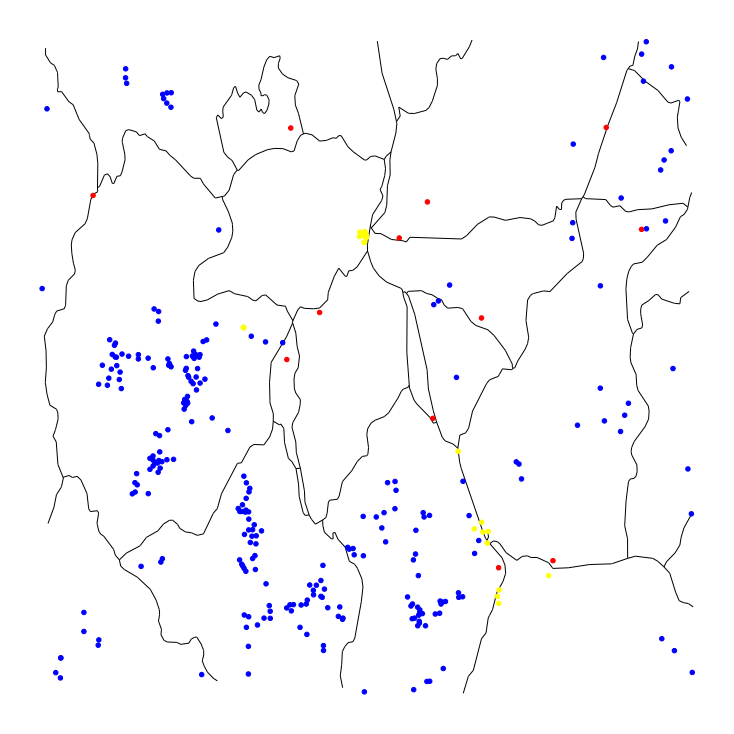

In [30]:
def poi_classification(com_index, min_size, visualize=False):
    """ Classifies the points of interest of a community corresponding to their category.
    Here, only the classes lake, airport and church are considered.
    
    Arguments:
    min_size -- minimal size of the community 
    com_index -- community index of where to start the search for a fitting community
    visualize -- true, if the chosen section with points of interest should be drawn 
    """ 
    _, places, com_index = choose_community(min_size, math.inf, 0.0, com_index)
    print("Chosen community: ", com_index)
    
    # have a rectangular section
    graph = filter_nodes_by_pos(G, list(nx.get_node_attributes(places, 'pos').values()))

    # classify between lake, airport and church
    categories = {3: 'lake', 2: 'airport', 1: 'church'}
    class_graph = filter_nodes_by_attribute(places, 'name', categories.values())
    
    if class_graph.number_of_nodes() < 100:
        print("Community has too little of the required points of interest to do a meaningful prediciton.")
        return
    
    if visualize:
        color_map = []
        nodes = nx.get_node_attributes(class_graph, 'name')
        for node in nodes.values():
            if node == categories[3]:
                color_map.append('blue')
            elif node == categories[2]:
                color_map.append('red')
            else:
                color_map.append('yellow')

        plt.figure(figsize=(10,10))
        nx.draw(graph, nx.get_node_attributes(graph, 'pos'), node_size = 0.0)
        nx.draw(class_graph, nx.get_node_attributes(class_graph, 'pos'), node_size = 20, node_color=color_map)
    
    # split nodes into test and training set
    test_pois = random.sample(class_graph.nodes(), int(0.1 * class_graph.number_of_nodes()))
    train_graph_poi = class_graph.copy()
    train_graph_poi.remove_nodes_from(test_pois)

    print("Size of training set: ", train_graph_poi.number_of_nodes())
    print("Size of test set: ", len(test_pois))

    # features and labels
    num_el_classes = [0, 0, 0]
    X = []
    y = []
    for n in train_graph_poi.nodes:
        X.append(poi_features(train_graph_poi, class_graph, graph, n))
        if train_graph_poi.nodes[n]['name'] == categories[3]:
            y.append(3)
            num_el_classes[2] = num_el_classes[2] + 1
        elif train_graph_poi.nodes[n]['name'] == categories[2]:
            y.append(2)
            num_el_classes[1] = num_el_classes[1] + 1
        else:
            y.append(1)
            num_el_classes[0] = num_el_classes[0] + 1
 
    if any(v < 5 for v in num_el_classes):
        print("Training set does not contain at least 5 elements in each class.")
        return

    test = [] 
    expected_y = []
    for n in test_pois:
        test.append(poi_features(train_graph_poi, class_graph, graph, n))
        if class_graph.nodes[n]['name'] == categories[3]:
            expected_y.append(3)
        elif class_graph.nodes[n]['name'] == categories[2]:
            expected_y.append(2)
        else:
            expected_y.append(1)

    predicted_y = qda_predict(X, y, test)

    m, _, _  = num_misclass(predicted_y, expected_y)
    print("misclassifications: ", m, " of ", len(predicted_y), " (", 100 - m*100/len(predicted_y), "% accuracy)")
    
poi_classification(0, 500, True)

In [ ]:
# test classification for all communities to get a range of accuracy
for i in range(58):
    if communities[i] != []:
        poi_classification(i, 0)
    print("\n")

Chosen community:  0
Size of training set:  272
Size of test set:  30
misclassifications:  2  of  30  ( 93.33333333333333 % accuracy)


Chosen community:  1
Size of training set:  154
Size of test set:  17
misclassifications:  3  of  17  ( 82.35294117647058 % accuracy)


Chosen community:  2
Size of training set:  228
Size of test set:  25
misclassifications:  1  of  25  ( 96.0 % accuracy)


Chosen community:  3
Community has too little of the required points of interest to do a meaningful prediciton.


Chosen community:  4
Community has too little of the required points of interest to do a meaningful prediciton.


Chosen community:  5
Size of training set:  489
Size of test set:  54
misclassifications:  4  of  54  ( 92.5925925925926 % accuracy)


Chosen community:  6
Community has too little of the required points of interest to do a meaningful prediciton.


Chosen community:  7
Size of training set:  117
Size of test set:  12
misclassifications:  0  of  12  ( 100.0 % accuracy)


Chos

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


misclassifications:  1  of  54  ( 98.14814814814815 % accuracy)


Chosen community:  21
Size of training set:  1431
Size of test set:  158
misclassifications:  9  of  158  ( 94.30379746835443 % accuracy)


Chosen community:  22
Size of training set:  486
Size of test set:  53
misclassifications:  6  of  53  ( 88.67924528301887 % accuracy)


Chosen community:  23
Size of training set:  431
Size of test set:  47


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


misclassifications:  3  of  47  ( 93.61702127659575 % accuracy)


Chosen community:  24
Size of training set:  796
Size of test set:  88
misclassifications:  7  of  88  ( 92.04545454545455 % accuracy)


Chosen community:  25
Size of training set:  638
Size of test set:  70
misclassifications:  5  of  70  ( 92.85714285714286 % accuracy)


Chosen community:  26
Size of training set:  476
Size of test set:  52
misclassifications:  4  of  52  ( 92.3076923076923 % accuracy)


Chosen community:  27
Community has too little of the required points of interest to do a meaningful prediciton.


Chosen community:  28
Size of training set:  398
Size of test set:  44
misclassifications:  7  of  44  ( 84.0909090909091 % accuracy)


Chosen community:  29
Community has too little of the required points of interest to do a meaningful prediciton.


Chosen community:  30
Size of training set:  497
Size of test set:  55
misclassifications:  6  of  55  ( 89.0909090909091 % accuracy)


Chosen community:  31
